# Pointing efficiency

Here, we want to evaluate the pointing efficiency of different ToO responses

In [1]:
import healpy as hp
import os
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
from matplotlib import pyplot as plt

# LSST Specific Libraries
from lsst_efd_client import EfdClient
from lsst.summit.utils.blockUtils import BlockParser
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
from lsst.summit.utils.tmaUtils import (
    getCommandsDuringEvent,
    TMAEvent,
    TMAEventMaker,
    TMAState,
)
import matplotlib.dates as mdates

import lsst.daf.butler as daf_butler
import pandas as pd

async def query_bump_logs_in_chunks(
    start_date,
    end_date,
    client_name="",
    chunk_size_days=3,
    topic_name="lsst.sal.MTM1M3.logevent_logMessage",
    fields=["message"],
):
    """
    Queries the log messages related to bump tests from the EFD in chunks.

    Args:
        start_date (str): Start date of the query in ISO format (YYYY-MM-DD).

        end_date (str): End date of the query in ISO format (YYYY-MM-DD).

        client_name (str, optional): Name of the EFD client. Defaults to "".

        chunk_size_days (int, optional): Number of days per chunk. Defaults to 3.

        topic_name (str, optional): SAL topic name to be queried by the client. Defaults to lsst.sal.MTM1M3.logevent_logMessage.

        fields (list[str], optional): Fields to be queried by the client. Defaults to ["message"].

    Returns:
        pandas.DataFrame: Concatenated DataFrame containing the queried log messages.
    """

    client = makeClient(client_name)

    # Convert start and end dates to datetime objects
    start = datetime.fromisoformat(start_date)
    end = datetime.fromisoformat(end_date)

    # Initialize an empty DataFrame to store concatenated results
    all_data = pd.DataFrame()

    current_start = start
    while current_start < end:
        current_end = min(current_start + timedelta(days=chunk_size_days), end)
        try:
            # Query the data for the current chunk
            chunk_data = await client.select_time_series(
                topic_name=topic_name,
                fields=fields,
                start=Time(current_start.isoformat(), format="isot", scale="utc"),
                end=Time(current_end.isoformat(), format="isot", scale="utc"),
            )
            # Concatenate the chunk data to the main DataFrame
            all_data = pd.concat([all_data, chunk_data], ignore_index=False)
        except Exception as e:
            print(
                f"Error querying data from {current_start.isoformat()} to {current_end.isoformat()}: {e}"
            )
            continue  # Optionally, continue to the next chunk

        # Move to the next chunk
        current_start = current_end

    return all_data


def makeClient(client_name):
    # Create the client based on client_name
    if client_name == "summit_efd":
        return makeEfdClient("summit_efd")
    elif client_name == "usdf_efd":
        return makeEfdClient("usdf_efd")
    elif client_name == "idf_efd":
        return makeEfdClient("idf_efd")
    else:
        return makeEfdClient()  # Default client


# Example usage:
# begin = "2023-11-13T01:00"
# end = "2023-12-21T01:00"
# bump_logs = await query_bump_logs_in_chunks(begin, end, client_name='')


def showAndClear():
    plt.show()
    # Clear the current axes.
    plt.cla()
    # Clear the current figure.
    plt.clf()
    # Closes all the figure windows.
    plt.close("all")
    plt.close(fig)

    return


async def getDataFrame(client, starts, ends, topic, verbose=True, fields=None):

    all_data = pd.DataFrame()
    for start, end in zip(starts, ends):
        if verbose:
            print(
                r"Starting query for time range {} - {}".format(start, end),
                end=" . . . ",
            )
        if fields != None:
            df_bump = await client.select_time_series(
                topic, fields, Time(start), Time(end)
            )
        else:
            df_bump = await client.select_time_series(
                topic, "*", Time(start), Time(end)
            )

        all_data = pd.concat([all_data, df_bump], ignore_index=False)

        del df_bump

        if verbose:
            print("Finished")

    return all_data


def makeDateRange(startPoint, endPoint, step=np.timedelta64(1, "D")):
    starts = np.arange(startPoint, endPoint, step=step)
    ends = starts + np.timedelta64(1, "D")
    return starts, ends


def fitGaussian(data, ax):
    mu, std = norm.fit(data)

    xmin, xmax = ax.get_xlim()
    x = np.linspace(np.floor(xmin), np.ceil(xmax), int(10e4))
    p = norm.pdf(x, mu, std)

    return mu, std, p, x, xmin, xmax


def getFWHM_from_gaussian(sigma):
    return 2 * np.sqrt(np.log(2) * 2) * sigma

plt.style.use("seaborn-v0_8-whitegrid")  

## S250725j

In [2]:
url = "https://gracedb.ligo.org/api/superevents/S250725j/files/bayestar.fits.gz"
myMap = hp.read_map(url)
eventName = "S250725j"

### First epoch

Here is the skymap for S250725j

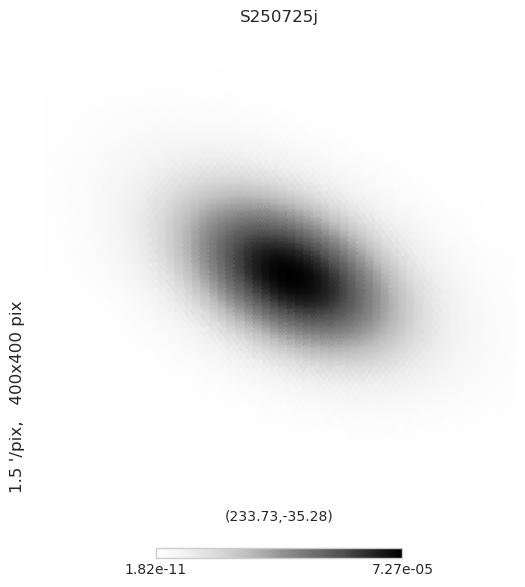

In [3]:
dim=400
hp.gnomview(myMap, title="S250725j", rot=np.array([233.73,-35.28]),xsize=dim,ysize=dim)
plt.show()

In [4]:
def findLevelIndices(mymap,level=0.9):
    i = np.flipud(np.argsort(mymap))
    sorted_credible_levels = np.cumsum(mymap[i])
    credible_levels = np.empty_like(sorted_credible_levels)
    credible_levels[i] = sorted_credible_levels
    levelIndices = np.arange(len(i))[credible_levels <= level]
    otherIndices = np.arange(len(i))[credible_levels > level]
    return levelIndices,otherIndices

In [5]:
indices50,nonIndices50 = findLevelIndices(myMap,0.5)
indices90,nonIndices90 = findLevelIndices(myMap,0.9)

In [6]:
mapCopy = myMap
mapCopy[indices90] = 1
mapCopy[indices50] = 2
mapCopy[nonIndices90] = 0

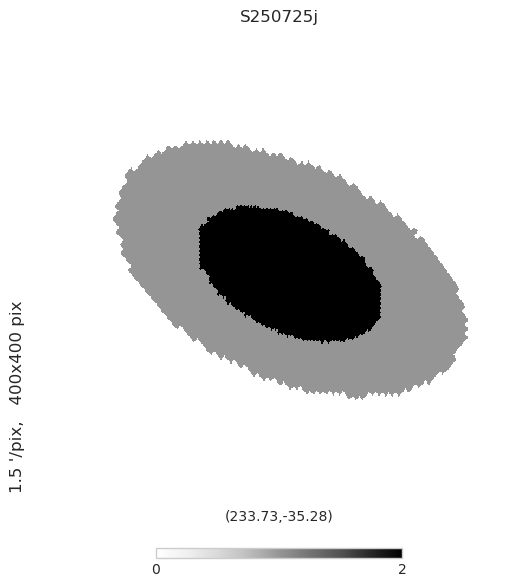

In [7]:
dim=400
hp.gnomview(mapCopy, title="S250725j", rot=np.array([233.73,-35.28]),xsize=dim,ysize=dim,min=0,max=2)
plt.show()

In [8]:
ROIMap = np.empty_like(myMap)
ROIMap[indices90] = 1

This is the region of interest that Rubin wants to tile for followup of S250725j

The BBH strategy is one pass in three filters over the entire 90% area. We want to evaluate the efficiency of covering this region

In [9]:
expNums = np.arange(2025072800099,2025072800159)
instrument="LSSTCam"

embargoButler = daf_butler.Butler("/repo/embargo",collections=['LSSTCam/raw/all','LSSTCam/calib/unbounded'])

dates1,dates2,filt,ras,decs = [],[],[],[],[]
for exp in expNums:
    mData = embargoButler.get('raw.metadata', detector=1, exposure=exp, instrument=instrument)
    expData = np.datetime64(mData["DATE-BEG"]) - np.timedelta64(37,"s")
    dates1.append(expData)
    dates2.append(np.datetime64(mData["DATE-END"]) - np.timedelta64(37,"s"))
    filt.append(mData["FILTBAND"])
    ras.append(np.median([mData["RASTART"],mData["RAEND"]]))
    decs.append(np.median([mData["DECSTART"],mData["DECEND"]]))

ToODF = pd.DataFrame(data=np.array([dates1,dates2,filt,ras,decs]).T,columns=["Start date","End date","Filter","RA","DEC"])

#### i band exposures

In [71]:
# compute total area covered in each pointing

def newAreaForPointing(vec,theMap,radius=1.75,fillValue=2):
    coveredIndices = hp.query_disc(hp.get_nside(theMap),vec,radius*np.pi/180)
    area = np.count_nonzero([x==1 for x in theMap[coveredIndices]]) * hp.nside2pixarea(hp.get_nside(theMap),degrees=True)
    theMap[coveredIndices] = fillValue
    return area,theMap

In [72]:
# setup
coveredMap90 = np.zeros_like(mapCopy)
coveredMap90[indices90] = 1
coveredMap50 = np.zeros_like(mapCopy)
coveredMap50[indices50] = 1

In [73]:
areaTime90 = [0]
areaTime50 = [0]
timeOfObs = [ToODF.iloc[0]["Start date"]]
for k in np.arange(10):
    row = ToODF.iloc[k]
    centerVec = hp.ang2vec(row["RA"],row["DEC"],lonlat=True)
    newArea90,coveredMap90 = newAreaForPointing(centerVec,coveredMap90)
    newArea50,coveredMap50 = newAreaForPointing(centerVec,coveredMap50)
    areaTime90.append(newArea90)
    areaTime50.append(newArea50)
    timeOfObs.append(row["End date"])

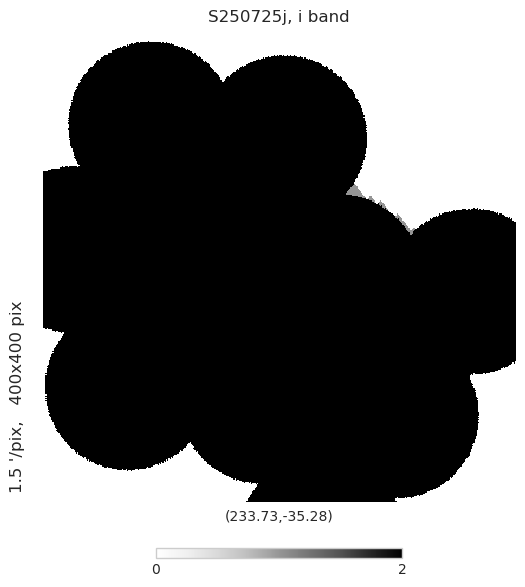

In [74]:
dim=400
hp.gnomview(coveredMap90, title="S250725j, i band", rot=np.array([233.73,-35.28]),xsize=dim,ysize=dim,min=0,max=2)
plt.show()

In [75]:
relevantArea90 = np.count_nonzero(coveredMap90[indices90]) * hp.nside2pixarea(hp.get_nside(coveredMap90),degrees=True)
relevantArea50 = np.count_nonzero(coveredMap50[indices50]) * hp.nside2pixarea(hp.get_nside(coveredMap50),degrees=True)

In [76]:
# fig,ax = plt.subplots(figsize=[10,6])
# ax.plot(timeOfObs,np.cumsum(areaTime90),"-o",label="90% region")
# ax.plot(timeOfObs,np.cumsum(areaTime50),"-o",label="50% region")
# ax.axhline(relevantArea90,color='red',label="90% area of {}".format(eventName))
# ax.axhline(relevantArea50,color='green',label="50% area of {}".format(eventName))
# ax.legend(framealpha=1)
# ax.grid(ls="-.")
# ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
# ax.set_ylabel("Area covered [deg$^2$]")

Text(0, 0.5, 'Proportion of relevant area covered [%]')

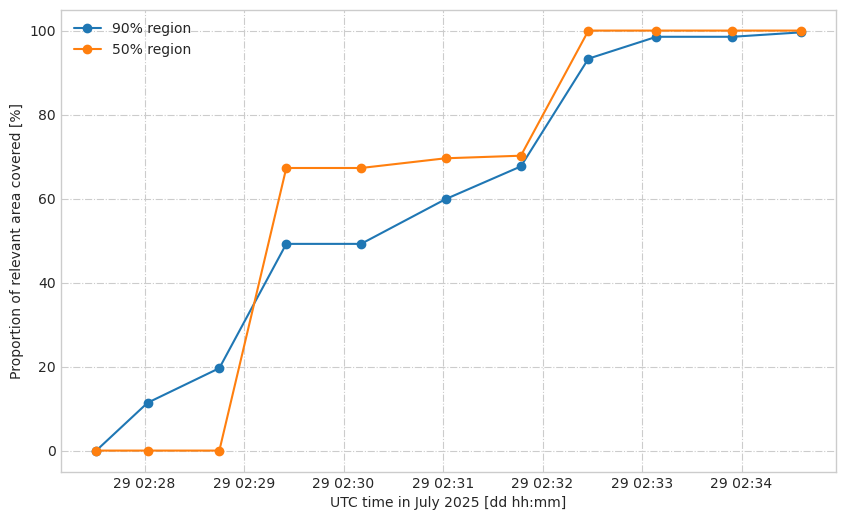

In [77]:
fig,ax = plt.subplots(figsize=[10,6])
ax.plot(timeOfObs,100*np.cumsum(areaTime90)/relevantArea90,"-o",label="90% region")
ax.plot(timeOfObs,100*np.cumsum(areaTime50)/relevantArea50,"-o",label="50% region")
ax.legend(framealpha=1)
ax.grid(ls="-.")
ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
ax.set_ylabel("Proportion of relevant area covered [%]")

In [78]:
100*np.cumsum(areaTime90)[-1]/relevantArea90,100*np.cumsum(areaTime50)[-1]/relevantArea50

(np.float64(99.576283568569), np.float64(100.00000000000001))

In [79]:
np.cumsum(areaTime90)[-1] / ((np.max(timeOfObs) - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 90% region

np.float64(3.9440316797947506)

In [81]:
np.cumsum(areaTime50)[-1] / ((timeOfObs[-4] - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 50% region

np.float64(1.6134644328677328)

#### r band exposures

In [82]:
# setup
coveredMap90 = np.zeros_like(mapCopy)
coveredMap90[indices90] = 1
coveredMap50 = np.zeros_like(mapCopy)
coveredMap50[indices50] = 1

In [83]:
areaTime90 = [0]
areaTime50 = [0]
timeOfObs = [ToODF.iloc[10]["Start date"]]
for k in np.arange(10,20):
    row = ToODF.iloc[k]
    centerVec = hp.ang2vec(row["RA"],row["DEC"],lonlat=True)
    newArea90,coveredMap90 = newAreaForPointing(centerVec,coveredMap90)
    newArea50,coveredMap50 = newAreaForPointing(centerVec,coveredMap50)
    areaTime90.append(newArea90)
    areaTime50.append(newArea50)
    timeOfObs.append(row["End date"])

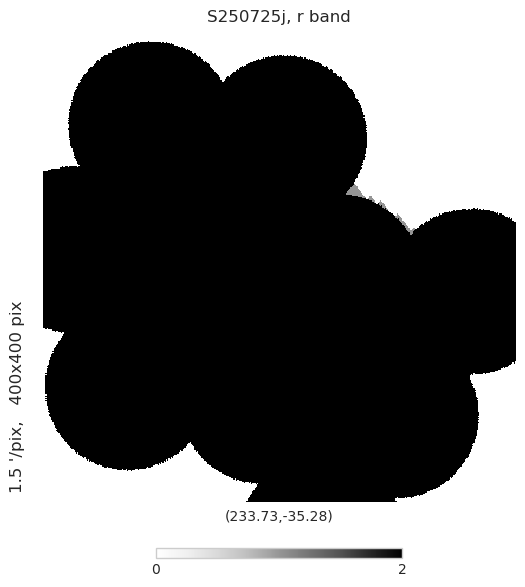

In [84]:
dim=400
hp.gnomview(coveredMap90, title="S250725j, r band", rot=np.array([233.73,-35.28]),xsize=dim,ysize=dim,min=0,max=2)
plt.show()

In [85]:
relevantArea90 = np.count_nonzero(coveredMap90[indices90]) * hp.nside2pixarea(hp.get_nside(coveredMap90),degrees=True)
relevantArea50 = np.count_nonzero(coveredMap50[indices50]) * hp.nside2pixarea(hp.get_nside(coveredMap50),degrees=True)

In [86]:
# fig,ax = plt.subplots(figsize=[10,6])
# ax.plot(timeOfObs,np.cumsum(areaTime90),"-o",label="90% region")
# ax.plot(timeOfObs,np.cumsum(areaTime50),"-o",label="50% region")
# ax.axhline(relevantArea90,color='red',label="90% area of {}".format(eventName))
# ax.axhline(relevantArea50,color='green',label="50% area of {}".format(eventName))
# ax.legend(framealpha=1)
# ax.grid(ls="-.")
# ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
# ax.set_ylabel("Area covered [deg$^2$]")

Text(0, 0.5, 'Proportion of relevant area covered [%]')

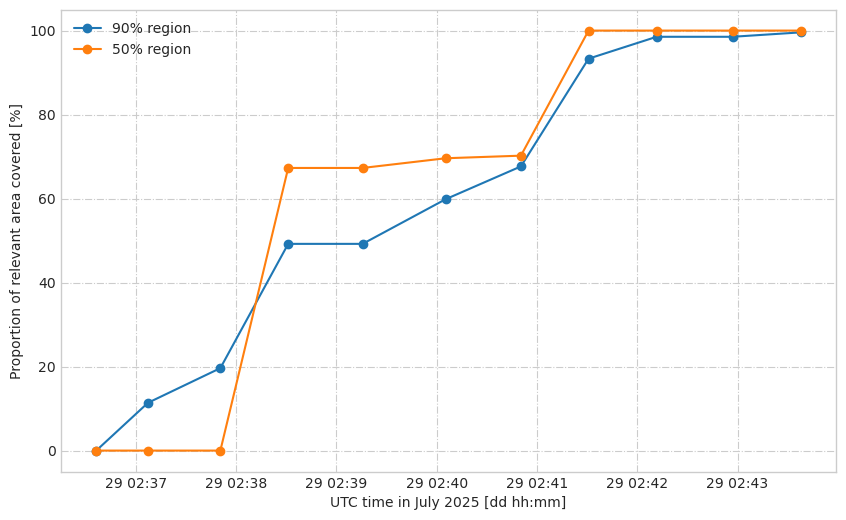

In [87]:
fig,ax = plt.subplots(figsize=[10,6])
ax.plot(timeOfObs,100*np.cumsum(areaTime90)/relevantArea90,"-o",label="90% region")
ax.plot(timeOfObs,100*np.cumsum(areaTime50)/relevantArea50,"-o",label="50% region")
ax.legend(framealpha=1)
ax.grid(ls="-.")
ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
ax.set_ylabel("Proportion of relevant area covered [%]")

In [88]:
100*np.cumsum(areaTime90)[-1]/relevantArea90,100*np.cumsum(areaTime50)[-1]/relevantArea50

(np.float64(99.576283568569), np.float64(100.0))

In [90]:
np.cumsum(areaTime90)[-1] / ((np.max(timeOfObs) - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 90% region

np.float64(3.976488455273616)

In [91]:
np.cumsum(areaTime50)[-1]/((timeOfObs[-4] - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 50% region

np.float64(1.6263190204189535)

#### u band exposures

In [92]:
# setup
coveredMap90 = np.zeros_like(mapCopy)
coveredMap90[indices90] = 1
coveredMap50 = np.zeros_like(mapCopy)
coveredMap50[indices50] = 1

In [93]:
areaTime90 = [0]
areaTime50 = [0]
timeOfObs = [ToODF.iloc[20]["Start date"]]
for k in np.arange(20,30):
    row = ToODF.iloc[k]
    centerVec = hp.ang2vec(row["RA"],row["DEC"],lonlat=True)
    newArea90,coveredMap90 = newAreaForPointing(centerVec,coveredMap90)
    newArea50,coveredMap50 = newAreaForPointing(centerVec,coveredMap50)
    areaTime90.append(newArea90)
    areaTime50.append(newArea50)
    timeOfObs.append(row["End date"])

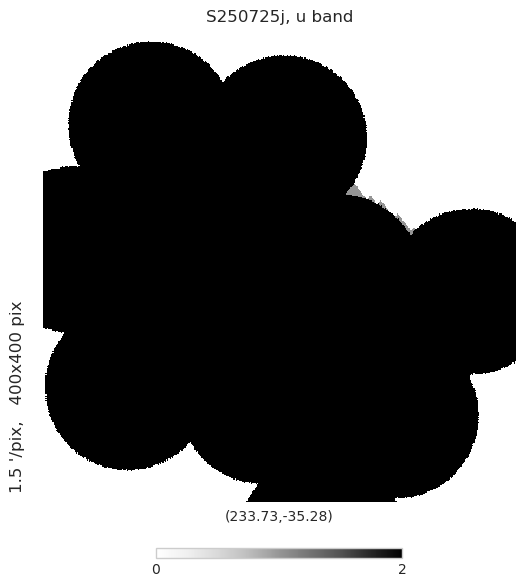

In [94]:
dim=400
hp.gnomview(coveredMap90, title="S250725j, u band", rot=np.array([233.73,-35.28]),xsize=dim,ysize=dim,min=0,max=2)
plt.show()

In [95]:
relevantArea90 = np.count_nonzero(coveredMap90[indices90]) * hp.nside2pixarea(hp.get_nside(coveredMap90),degrees=True)
relevantArea50 = np.count_nonzero(coveredMap50[indices50]) * hp.nside2pixarea(hp.get_nside(coveredMap50),degrees=True)

In [96]:
# fig,ax = plt.subplots(figsize=[10,6])
# ax.plot(timeOfObs,np.cumsum(areaTime90),"-o",label="90% region")
# ax.plot(timeOfObs,np.cumsum(areaTime50),"-o",label="50% region")
# ax.axhline(relevantArea90,color='red',label="90% area of {}".format(eventName))
# ax.axhline(relevantArea50,color='green',label="50% area of {}".format(eventName))
# ax.legend(framealpha=1)
# ax.grid(ls="-.")
# ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
# ax.set_ylabel("Area covered [deg$^2$]")

Text(0, 0.5, 'Proportion of relevant area covered [%]')

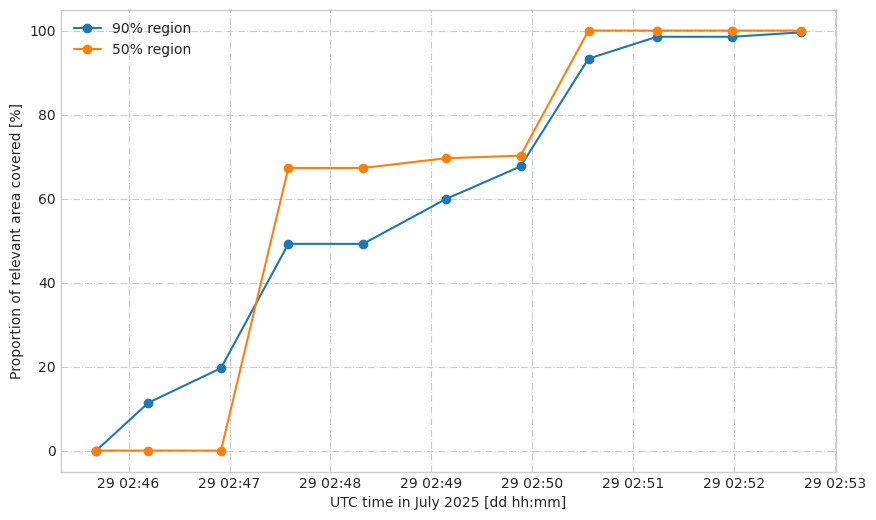

In [97]:
fig,ax = plt.subplots(figsize=[10,6])
ax.plot(timeOfObs,100*np.cumsum(areaTime90)/relevantArea90,"-o",label="90% region")
ax.plot(timeOfObs,100*np.cumsum(areaTime50)/relevantArea50,"-o",label="50% region")
ax.legend(framealpha=1)
ax.grid(ls="-.")
ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
ax.set_ylabel("Proportion of relevant area covered [%]")

In [98]:
100*np.cumsum(areaTime90)[-1]/relevantArea90,100*np.cumsum(areaTime50)[-1]/relevantArea50

(np.float64(99.576283568569), np.float64(100.0))

In [99]:
np.cumsum(areaTime90)[-1] / ((np.max(timeOfObs) - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 90% region

np.float64(4.001948207072089)

In [100]:
np.cumsum(areaTime50)[-1]/((timeOfObs[-4] - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 50% region

np.float64(1.6369032854702519)

#### i band exposures, second pass

In [101]:
# setup
coveredMap90 = np.zeros_like(mapCopy)
coveredMap90[indices90] = 1
coveredMap50 = np.zeros_like(mapCopy)
coveredMap50[indices50] = 1

In [102]:
areaTime90 = [0]
areaTime50 = [0]
timeOfObs = [ToODF.iloc[30]["Start date"]]
for k in np.arange(30,40):
    row = ToODF.iloc[k]
    centerVec = hp.ang2vec(row["RA"],row["DEC"],lonlat=True)
    newArea90,coveredMap90 = newAreaForPointing(centerVec,coveredMap90)
    newArea50,coveredMap50 = newAreaForPointing(centerVec,coveredMap50)
    areaTime90.append(newArea90)
    areaTime50.append(newArea50)
    timeOfObs.append(row["End date"])

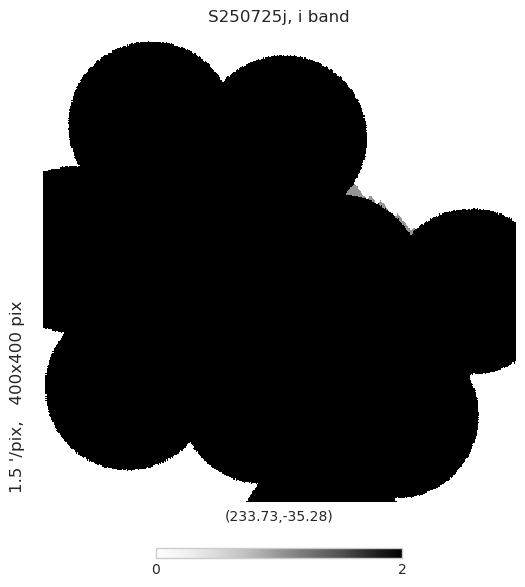

In [103]:
dim=400
hp.gnomview(coveredMap90, title="S250725j, i band", rot=np.array([233.73,-35.28]),xsize=dim,ysize=dim,min=0,max=2)
plt.show()

In [104]:
relevantArea90 = np.count_nonzero(coveredMap90[indices90]) * hp.nside2pixarea(hp.get_nside(coveredMap90),degrees=True)
relevantArea50 = np.count_nonzero(coveredMap50[indices50]) * hp.nside2pixarea(hp.get_nside(coveredMap50),degrees=True)

In [105]:
# fig,ax = plt.subplots(figsize=[10,6])
# ax.plot(timeOfObs,np.cumsum(areaTime90),"-o",label="90% region")
# ax.plot(timeOfObs,np.cumsum(areaTime50),"-o",label="50% region")
# ax.axhline(relevantArea90,color='red',label="90% area of {}".format(eventName))
# ax.axhline(relevantArea50,color='green',label="50% area of {}".format(eventName))
# ax.legend(framealpha=1)
# ax.grid(ls="-.")
# ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
# ax.set_ylabel("Area covered [deg$^2$]")

Text(0, 0.5, 'Proportion of relevant area covered [%]')

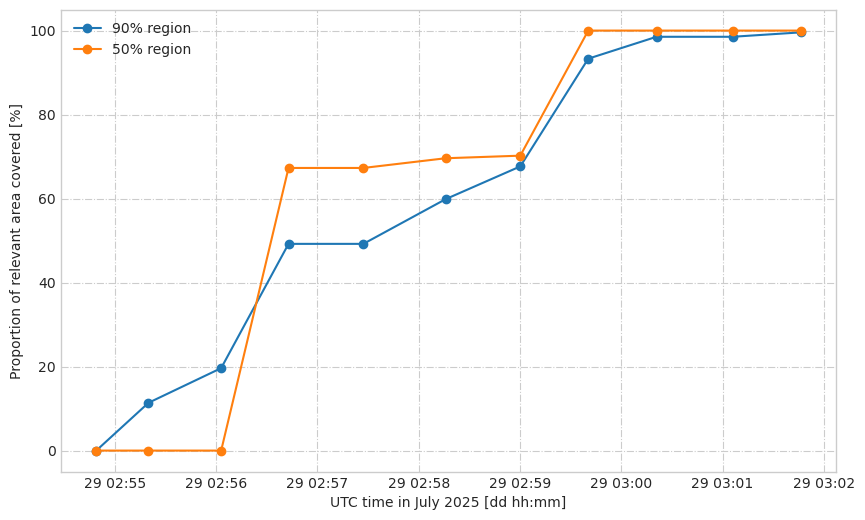

In [106]:
fig,ax = plt.subplots(figsize=[10,6])
ax.plot(timeOfObs,100*np.cumsum(areaTime90)/relevantArea90,"-o",label="90% region")
ax.plot(timeOfObs,100*np.cumsum(areaTime50)/relevantArea50,"-o",label="50% region")
ax.legend(framealpha=1)
ax.grid(ls="-.")
ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
ax.set_ylabel("Proportion of relevant area covered [%]")

In [107]:
100*np.cumsum(areaTime90)[-1]/relevantArea90,100*np.cumsum(areaTime50)[-1]/relevantArea50

(np.float64(99.576283568569), np.float64(100.0))

In [108]:
np.cumsum(areaTime90)[-1] / ((np.max(timeOfObs) - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 90% region

np.float64(4.016171857336525)

In [109]:
np.cumsum(areaTime50)[-1]/((timeOfObs[-4] - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 50% region

np.float64(1.6435548518076628)

#### r band exposures, second pass

In [110]:
# setup
coveredMap90 = np.zeros_like(mapCopy)
coveredMap90[indices90] = 1
coveredMap50 = np.zeros_like(mapCopy)
coveredMap50[indices50] = 1

In [111]:
areaTime90 = [0]
areaTime50 = [0]
timeOfObs = [ToODF.iloc[40]["Start date"]]
for k in np.arange(40,50):
    row = ToODF.iloc[k]
    centerVec = hp.ang2vec(row["RA"],row["DEC"],lonlat=True)
    newArea90,coveredMap90 = newAreaForPointing(centerVec,coveredMap90)
    newArea50,coveredMap50 = newAreaForPointing(centerVec,coveredMap50)
    areaTime90.append(newArea90)
    areaTime50.append(newArea50)
    timeOfObs.append(row["End date"])

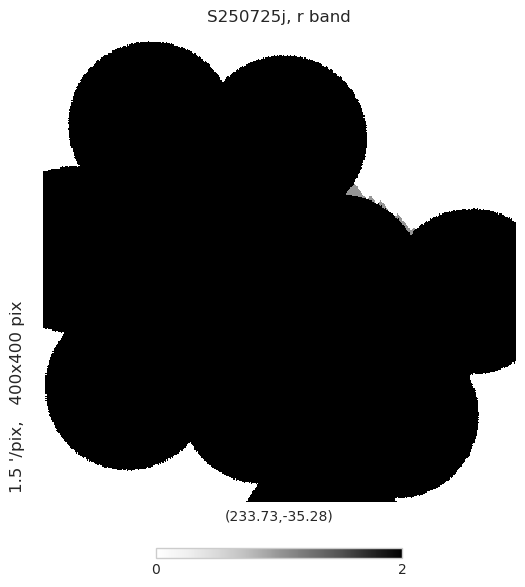

In [112]:
dim=400
hp.gnomview(coveredMap90, title="S250725j, r band", rot=np.array([233.73,-35.28]),xsize=dim,ysize=dim,min=0,max=2)
plt.show()

In [113]:
relevantArea90 = np.count_nonzero(coveredMap90[indices90]) * hp.nside2pixarea(hp.get_nside(coveredMap90),degrees=True)
relevantArea50 = np.count_nonzero(coveredMap50[indices50]) * hp.nside2pixarea(hp.get_nside(coveredMap50),degrees=True)

In [114]:
# fig,ax = plt.subplots(figsize=[10,6])
# ax.plot(timeOfObs,np.cumsum(areaTime90),"-o",label="90% region")
# ax.plot(timeOfObs,np.cumsum(areaTime50),"-o",label="50% region")
# ax.axhline(relevantArea90,color='red',label="90% area of {}".format(eventName))
# ax.axhline(relevantArea50,color='green',label="50% area of {}".format(eventName))
# ax.legend(framealpha=1)
# ax.grid(ls="-.")
# ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
# ax.set_ylabel("Area covered [deg$^2$]")

Text(0, 0.5, 'Proportion of relevant area covered [%]')

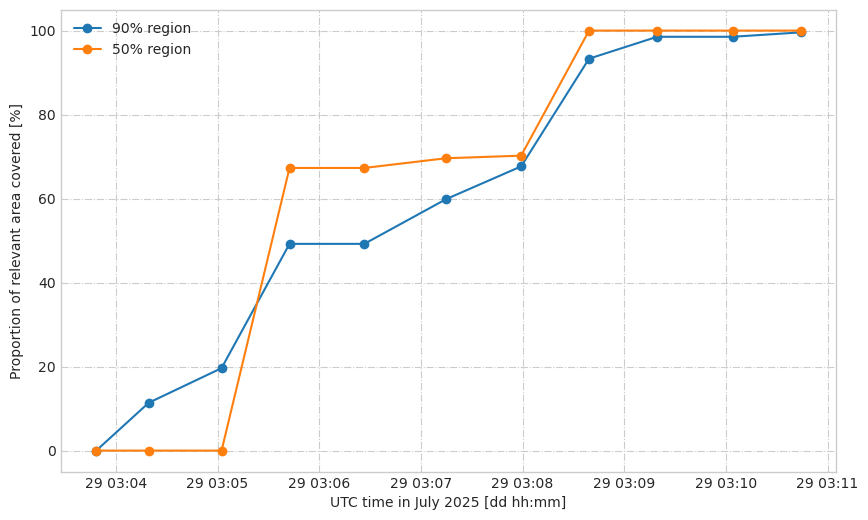

In [115]:
fig,ax = plt.subplots(figsize=[10,6])
ax.plot(timeOfObs,100*np.cumsum(areaTime90)/relevantArea90,"-o",label="90% region")
ax.plot(timeOfObs,100*np.cumsum(areaTime50)/relevantArea50,"-o",label="50% region")
ax.legend(framealpha=1)
ax.grid(ls="-.")
ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
ax.set_ylabel("Proportion of relevant area covered [%]")

In [116]:
100*np.cumsum(areaTime90)[-1]/relevantArea90,100*np.cumsum(areaTime50)[-1]/relevantArea50

(np.float64(99.576283568569), np.float64(100.0))

In [117]:
np.cumsum(areaTime90)[-1] / ((np.max(timeOfObs) - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 90% region

np.float64(4.030778120937579)

In [118]:
np.cumsum(areaTime50)[-1]/((timeOfObs[-4] - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 50% region

np.float64(1.6468669662799218)

#### u band exposures, second pass

In [119]:
# setup
coveredMap90 = np.zeros_like(mapCopy)
coveredMap90[indices90] = 1
coveredMap50 = np.zeros_like(mapCopy)
coveredMap50[indices50] = 1

In [120]:
areaTime90 = [0]
areaTime50 = [0]
timeOfObs = [ToODF.iloc[50]["Start date"]]
for k in np.arange(50,60):
    row = ToODF.iloc[k]
    centerVec = hp.ang2vec(row["RA"],row["DEC"],lonlat=True)
    newArea90,coveredMap90 = newAreaForPointing(centerVec,coveredMap90)
    newArea50,coveredMap50 = newAreaForPointing(centerVec,coveredMap50)
    areaTime90.append(newArea90)
    areaTime50.append(newArea50)
    timeOfObs.append(row["End date"])

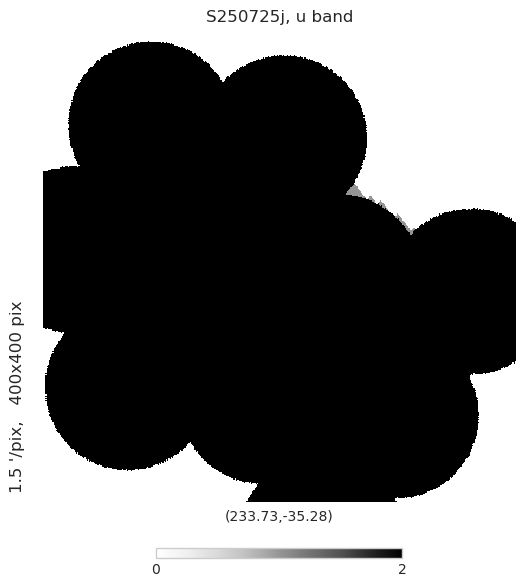

In [121]:
dim=400
hp.gnomview(coveredMap90, title="S250725j, u band", rot=np.array([233.73,-35.28]),xsize=dim,ysize=dim,min=0,max=2)
plt.show()

In [122]:
relevantArea90 = np.count_nonzero(coveredMap90[indices90]) * hp.nside2pixarea(hp.get_nside(coveredMap90),degrees=True)
relevantArea50 = np.count_nonzero(coveredMap50[indices50]) * hp.nside2pixarea(hp.get_nside(coveredMap50),degrees=True)

In [123]:
# fig,ax = plt.subplots(figsize=[10,6])
# ax.plot(timeOfObs,np.cumsum(areaTime90),"-o",label="90% region")
# ax.plot(timeOfObs,np.cumsum(areaTime50),"-o",label="50% region")
# ax.axhline(relevantArea90,color='red',label="90% area of {}".format(eventName))
# ax.axhline(relevantArea50,color='green',label="50% area of {}".format(eventName))
# ax.legend(framealpha=1)
# ax.grid(ls="-.")
# ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
# ax.set_ylabel("Area covered [deg$^2$]")

Text(0, 0.5, 'Proportion of relevant area covered [%]')

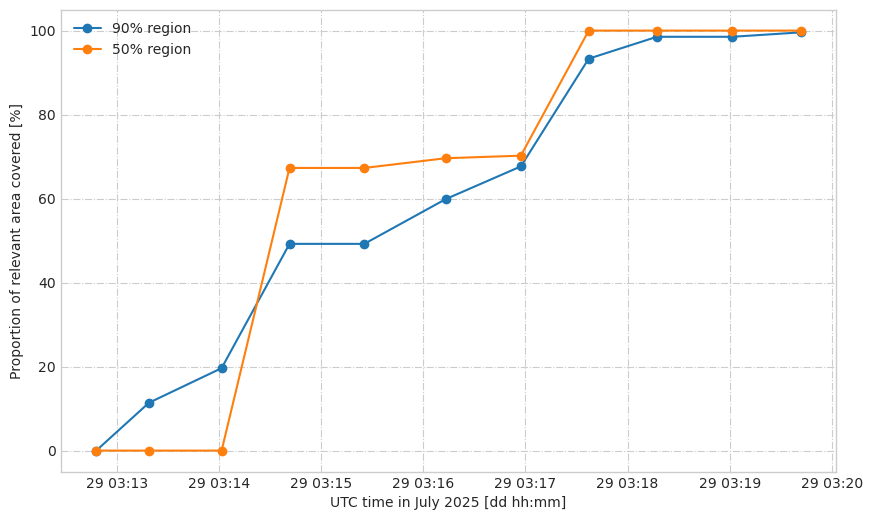

In [124]:
fig,ax = plt.subplots(figsize=[10,6])
ax.plot(timeOfObs,100*np.cumsum(areaTime90)/relevantArea90,"-o",label="90% region")
ax.plot(timeOfObs,100*np.cumsum(areaTime50)/relevantArea50,"-o",label="50% region")
ax.legend(framealpha=1)
ax.grid(ls="-.")
ax.set_xlabel("UTC time in July 2025 [dd hh:mm]")
ax.set_ylabel("Proportion of relevant area covered [%]")

In [125]:
100*np.cumsum(areaTime90)[-1]/relevantArea90,100*np.cumsum(areaTime50)[-1]/relevantArea50

(np.float64(99.576283568569), np.float64(100.0))

In [126]:
np.cumsum(areaTime90)[-1] / ((np.max(timeOfObs) - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 90% region

np.float64(4.047904721759663)

In [127]:
np.cumsum(areaTime50)[-1]/((timeOfObs[-4] - np.min(timeOfObs)).value * 10**-9 / 60) # deg/min covered of the 50% region

np.float64(1.6549714248856318)

# Summary

| Filter, pass        | Rate of 50% region coverage [deg/min] | Rate of 90% region coverage [deg/min] |
|---------------------|---------------------------------------|---------------------------------------|
| i band, first pass  | 1.613                                 | 3.944                                 |
| r band, first pass  | 1.626                                 | 3.977                                 |
| u band, first pass  | 1.637                                 | 4.002                                 |
| i band, second pass | 1.644                                 | 4.016                                 |
| r band, second pass | 1.647                                 | 4.031                                 |
| u band, second pass | 1.654                                 | 4.078                                 |

For each pass in each filter, 100% of the 50% probability region was covered, and 99.576% of the 90% region was covered. Additionally, the 50% region was covered at a rate of 1.64 deg/min, and the 90% region was covered at a rate of 4 deg/min.